In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Principal Component Analysis

We have looked at many supervised learning algorithms for classification: models that give predictions based on labelled training data. We have also looked at some unsupervised estimators, which can provide some sense of the structure present in a dataset, without any reference to known labels, e.g. k-Means clustering.

In this lecture, we will explore a very powerful technique, one of the most broadly used methods in unsupervised algorithms, called Principal Component Analysis (PCA).

PCA is fundamentally a dimensionality reduction algorithm, but it can also be useful as a tool for visualization, for noise filtering, for feature extraction and engineering, and much more. After a brief conceptual discussion of the PCA algorithm, we will see a couple examples of these further applications.

## Introducing PCA
Principal component analysis is a fast and flexible unsupervised method for dimensionality reduction in data. Its behavior is easiest to visualize by looking at a two-dimensional dataset. Consider the following 200 points:

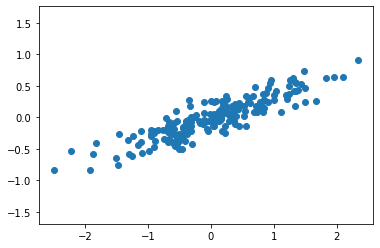

In [2]:
rng = np.random.RandomState(1)
X = np.dot(rng.rand(2, 2), rng.randn(2, 200)).T
plt.scatter(X[:, 0], X[:, 1])
plt.axis('equal');

By eye, it is clear that there is a nearly linear relationship between the x and y variables. This is reminiscent of the linear regression data we explored earlier, but the problem setting here is slightly different: rather than attempting to predict the y values from the x values, the unsupervised learning problem attempts to learn about the relationship between the x and y values.

In principal component analysis, this relationship is quantified by finding a list of the principal axes in the data, and using those axes to describe the dataset. Using Scikit-Learn's PCA estimator, we can compute this as follows:

In [3]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

The fit learns some quantities from the data, most importantly the "components" and "explained variance":

In [4]:
print(pca.components_)

[[-0.94446029 -0.32862557]
 [-0.32862557  0.94446029]]


In [5]:
print(pca.explained_variance_)

[0.7625315 0.0184779]


To see what these numbers mean, let's visualize them as vectors over the input data, using the "components" to define the direction of the vector, and the "explained variance" to define the squared-length of the vector:

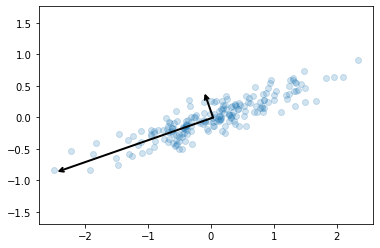

In [6]:
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)

# plot data
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v)
plt.axis('equal');

These vectors represent the principal axes of the data, and the length of the vector is an indication of how "important" that axis is in describing the distribution of the data—more precisely, it is a measure of the variance of the data when projected onto that axis. The projection of each data point onto the principal axes are the "principal components" of the data.

This transformation from data axes to principal axes is an affine transformation, which basically means it is composed of a translation, rotation, and uniform scaling.

While this algorithm to find principal components may seem like just a mathematical curiosity, it turns out to have very far-reaching applications in the world of machine learning and data exploration.

## PCA for Dimensionality Reduction
Using PCA for dimensionality reduction involves zeroing out one or more of the smallest principal components, resulting in a lower-dimensional projection of the data that preserves the maximal data variance.

Here is an example of using PCA as a dimensionality reduction transform:

In [7]:
pca = PCA(n_components=1)
pca.fit(X)
X_pca = pca.transform(X)
print("original shape:   ", X.shape)
print("transformed shape:", X_pca.shape)

original shape:    (200, 2)
transformed shape: (200, 1)


The transformed data has been reduced to a single dimension. To understand the effect of this dimensionality reduction, we can perform the inverse transform of this reduced data and plot it along with the original data:

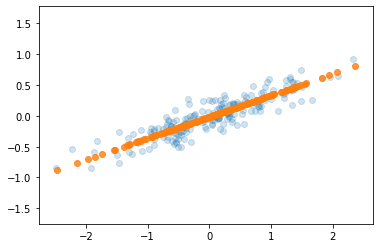

In [8]:
X_new = pca.inverse_transform(X_pca)
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
plt.scatter(X_new[:, 0], X_new[:, 1], alpha=0.8)
plt.axis('equal');

The light points are the original data, while the dark points are the projected version. This makes clear what a PCA dimensionality reduction means: the information along the least important principal axis or axes is removed, leaving only the component(s) of the data with the highest variance. The fraction of variance that is cut out (proportional to the spread of points about the line formed in this figure) is roughly a measure of how much "information" is discarded in this reduction of dimensionality.

This reduced-dimension dataset is in some sense "good enough" to encode the most important relationships between the points: despite reducing the dimension of the data by 50%, the overall relationship between the data points are mostly preserved.

## PCA for Visualization
The usefulness of the dimensionality reduction may not be entirely apparent in only two dimensions, but becomes much more clear when looking at high-dimensional data. To see this, let's take a quick look at the application of PCA to the Star vs. LL-Rylae data:

In [9]:
# Load up RRLyrae Dataset
data = np.load('./data/rrlyrae.npz')
samples = data['data']
labels = data['labels']
samples.shape

(93141, 4)

Recall how our samples all had 4-dimensions, and we were mostly plotting the first 2 dimensions only to observe how various classifiers were performing.

To gain some intuition into the relationships between these data points, we can now use PCA to project them to a more manageable number of dimensions (two):

In [10]:
pca = PCA(2)  # project from 64 to 2 dimensions
projected = pca.fit_transform(samples)
print(samples.shape)
print(projected.shape)

(93141, 4)
(93141, 2)


We can now plot the first two principal components of each point to learn about the data:

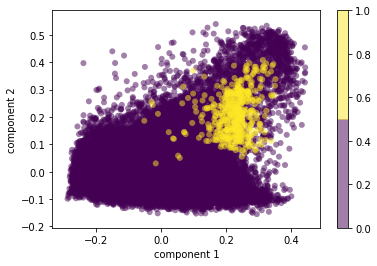

In [11]:
plt.scatter(projected[:, 0], projected[:, 1],
            c=labels, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('viridis', 2))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

Recall what these components mean: the full data is a 4-dimensional point cloud, and these points are the projection of each data point along the directions with the largest variance. Essentially, we have found the optimal stretch and rotation in 4-dimensional space that allows us to see the layout of the samples in two dimensions, and have done this in an unsupervised manner—that is, without reference to the labels.

## Choosing the Number of Components
A vital part of using PCA in practice is the ability to estimate how many components are needed to describe the data. This can be determined by looking at the cumulative explained variance ratio as a function of the number of components:

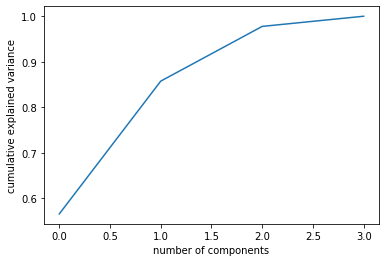

In [12]:
pca = PCA().fit(samples)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

This curve quantifies how much of the total, 4-dimensional variance is contained within the first N components. For example, we see that with  the first component contains approximately 85% of the variance, while you need 3 components to describe close to 100% of the variance.

Here we see that our two-dimensional projection loses some information (as measured by the explained variance) and that we'd need about 3 dimensions components to retain 90% or more of the variance. Looking at this plot for a high-dimensional dataset can help you understand the level of redundancy present in multiple observations.

## Dimensionality Reduction of Astronomical Spectra
The Sloan Digital Sky Survey is a photometric and spectroscopic survey which has operated since the year 2000, and has resulted in an unprecedented astronomical database. The database contains photometric observations like those we explored in the previous sections, but also includes a large number of spectra of various objects. These spectra are n-dimensional data vectors (generally, $n \approx 4000$) for each observed object, where each observation in the vector measures the flux of a particular wavelength of light.

Because of the large dimensionality of this data, visualization of the dataset becomes very challenging. This is where unsupervised dimensionality reduction methods can be useful. So we shall try out PCA. We won't go through the mathematical details here, but keep in mind that PCA essentially seeks dimensions of the input data which contain the bulk of the variability present in the data. The model has this form:
\begin{equation}
\vec{x_i} = \vec{\mu} + \sum_{j = 1}^n a_{ij} \vec{v_j}
\end{equation}

Here $\vec{x_i}$ represents an individual spectrum. $\vec{\mu}$ is the mean spectrum for the dataset. The remaining term encodes the contributions of each of the eigenvectors $\vec{v_j}$. The eigenvectors are generally arranged so that those with the smallest $j$ contain the most signal-to-noise, and are the most important vectors in reconstructing the spectra. For this reason, truncating the sum at some $m < n$ can still result in a faithful representation of the input. 

For astronomical spectra, the result is that the first few coefficientts $a_{ij}$ of each spectrum $\vec{x_i}$ encode a good low-dimensional representation of the spectrum. We'll use this fact to visualize this data in a meaningful way.

In [13]:
def reconstruct_spectra(data):
    spectra = data['spectra']
    coeffs = data['coeffs']
    evecs = data['evecs']
    mask = data['mask']
    mu = data['mu']
    norms = data['norms']
    spec_recons = spectra.copy()
    nev = coeffs.shape[1]
    spec_fill = mu + np.dot(coeffs, evecs[:nev])
    spec_fill *= norms[:, np.newaxis]
    spec_recons[mask] = spec_fill[mask]
    return spec_recons


def compute_wavelengths(data):
    return 10 ** (data['coeff0']
                  + data['coeff1'] * np.arange(data['spectra'].shape[1]))


data = np.load('./data/spec4000.npz')
spectra = reconstruct_spectra(data)
wavelengths = compute_wavelengths(data)

print(spectra.shape)
print(wavelengths.shape)

(4000, 1000)
(1000,)


Our data (spectra) contains 4000 spectra, each with 1000 attributes. In addition, the data includes an array wavelengths, corresponding to the 1000 attributes of each spectrum. Let' plot a single spectrum:

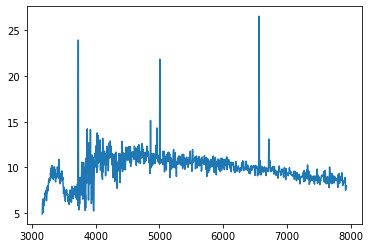

In [14]:
single_spectrum = spectra[0]
plt.plot(wavelengths,single_spectrum)
plt.show()

There are 4000 spectra in this file, each with 1000 attributes. Visualizing a dataset of this size can be very difficult. We could plot all 4000 spectra as we did above, but the plot would quickly become too complicated. As a first step, it might be helpful to ask what the average spectrum looks like. To do this, we’ll plot the mean, but first we’ll normalize the spectra. Because the spectra represent galaxies at distances that range over several hundreds of light-years, their total flux varies greatly. Thus it will help if we normalize the spectra. For this we’ll use the scikit-learn preprocessing module. We’ll then plot both the mean and standard deviation to give us an idea of the data we’re working with:

Text(0.5, 1.0, 'Mean Spectrum')

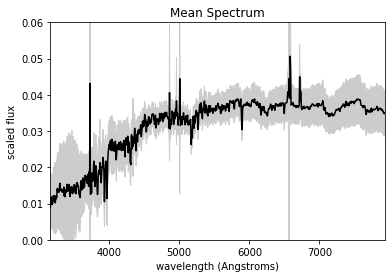

In [15]:
from sklearn import preprocessing
spectra = preprocessing.normalize(spectra)
mu = spectra.mean(0)
std = spectra.std(0)
plt.plot(wavelengths, mu, color='black')
plt.fill_between(wavelengths, mu - std, mu + std, color='#CCCCCC')
plt.xlim(wavelengths[0], wavelengths[-1])
plt.ylim(0, 0.06)
plt.xlabel('wavelength (Angstroms)')
plt.ylabel('scaled flux')
plt.title('Mean Spectrum')

The plot above shows the mean and standard deviation of the normalized spectra. Some of the largest variation is found at wavelengths at which Hydrogen absorbs and emits photons (Hydrogen is by far the most abundant atom in the universe). For example, the line at 6563 is known as Hydrogen-$\alpha$, and is often seen in emission (spiking up) in quasars and other active galaxies.

The interesting part of the data is in the gray shaded regions: how do spectra vary from the mean, and how can this variation tell us about their physical properties? One option to visualize this would be to scatter-plot random pairs of observations from each spectrum. We’ll first create a formatter object to make the colorbar labels pretty, and then plot some data pairs:

Text(0.5, 1.0, 'Random Pair of Spectra Bins')

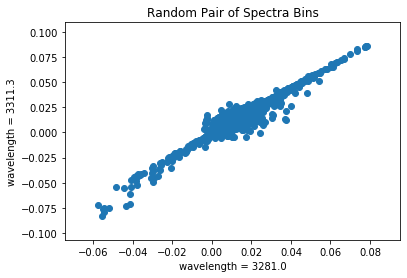

In [16]:
np.random.seed(25255)  # this seed is chosen to emphasize correlation
i1, i2 = np.random.randint(1000, size=2)
plt.scatter(spectra[:, i1], spectra[:, i2])
plt.xlabel('wavelength = %.1f' % wavelengths[i1])
plt.ylabel('wavelength = %.1f' % wavelengths[i2])
plt.title('Random Pair of Spectra Bins')

There is a clear correlation between these two measurements. That is, if you know the value of one, then you could quite accurately predict the value of the other. This shows us that some of the spectral bins do not add much information, and can be ignored. One could imagine proceeding by trial and error, plotting pairs of attributes and seeing which ones provide the most interesting information, but this would be very tedious. Instead, we can use an automated technique for dimensionality reduction: PCA.

In [17]:
pca = PCA(4)  # project to just 4 dimensions
spectra_projected = pca.fit_transform(spectra)
print(spectra_projected.shape)

(4000, 4)


spectra_projected is now a reduced-dimension representation of spectra, where the lower-index columns are the most important dimensions. We can visualize the spectra now using the first two columns:

Text(0.5, 1.0, 'PCA projection of Spectra')

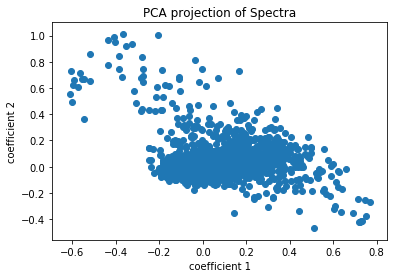

In [18]:
plt.scatter(spectra_projected[:, 0], spectra_projected[:, 1])
plt.xlabel('coefficient 1')
plt.ylabel('coefficient 2')
plt.title('PCA projection of Spectra')

We now have a two-dimensional visualization, but what does this tell us? Looking at the PCA model in the equation above, we see that each component is associated with an eigenvector, and this plot is showing $a_{i1}$ and $a_{i2}$ where:
\begin{equation}
\vec{s_i} \approx \vec{\mu} + a_{i1}\vec{v_1} + a_{i2}\vec{v_2}
\end{equation}

## Summary
In this short lecture we have discussed the use of principal component analysis for dimensionality reduction and for visualization of high-dimensional data. The benefits of PCA come in whenever we need to reduce a dataset at hand, or whether the dimensionality of our data is needlessly too high for classification purposes. This is not the case for a 4-dimensional dataset, but there will be cases where the dimensionality is much higher, such as with SDSS spectra. In such a case, analysis by PCA will most definitely be another useful tool in your arsenal.

Because of the versatility and interpretability of PCA, it has been shown to be effective in a wide variety of contexts and disciplines. Given any high-dimensional dataset, it is always useful to start with PCA in order to visualize the relationship between points (as we did with the Star data), to understand the main variance in the data, and to understand the intrinsic dimensionality (by plotting the explained variance ratio). Certainly PCA is not useful for every high-dimensional dataset, but it offers a straightforward and efficient path to gaining insight into high-dimensional data.

PCA's main weakness is that it tends to be highly affected by outliers in the data. For this reason, many robust variants of PCA have been developed, many of which act to iteratively discard data points that are poorly described by the initial components. Scikit-Learn contains a couple of interesting variants on PCA, including RandomizedPCA and SparsePCA, both also in the sklearn.decomposition submodule. RandomizedPCA uses a non-deterministic method to quickly approximate the first few principal components in very high-dimensional data, while SparsePCA introduces a regularization term  that serves to enforce sparsity of the components.